# Vision Quest

In [1]:
import jyro.simulator as jy
import conx as cx
from IPython.display import display
import random
import numpy as np

Using TensorFlow backend.
ConX, version 3.7.4


In [2]:
def make_world(physics):
    physics.addBox(0, 0, 5, 5, fill="gray", wallcolor="gray")
    physics.addBox(0, 0, 0.5, 0.5, fill="blue", wallcolor="blue")
    physics.addBox(0, 5, 0.5, 4.5 , fill="red", wallcolor="red")
    physics.addBox(4.5, 4.5, 5, 5, fill="green", wallcolor="green")
    physics.addBox(4.5, 0, 5, 0.5, fill="purple", wallcolor="purple")
    physics.addBox(2, 1.75, 2.5, 3.25, fill="orange", wallcolor="orange")
    physics.addLight(3, 2.5, 1)

def make_robot():
    robot = jy.Pioneer("Pioneer", 3, 1, 0) 
    robot.addDevice(jy.Camera())
    robot.addDevice(jy.Pioneer16Sonars())
    robot.addDevice(jy.PioneerFrontLightSensors(3))
    return robot

robot = make_robot()
robot.mystep = 0
robot.priority = random.choice(["left", "right"])
sim = jy.Simulator(robot, make_world)

def get_quadrant(x, y, max_x=5, max_y=5):
    if x <= max_x/2 and y <= max_y/2:
        return 1
    elif x <= max_x/2 and y >= max_y/2:
        return 2
    elif x >= max_x/2 and y >= max_y/2:
        return 3
    else:
        return 4

SAMPLES = 500
    
def controller(robot):
    if robot.mystep % 200 == 0:
        robot.priority = "left" if robot.priority == "right" else "right"
    image = robot["camera"].getData()
    
    x, y, h = robot.getPose()
    quad = get_quadrant(x, y)
    
    ls = list(robot.targets)
    counts = [ls.count(n) for n in [1,2,3,4]]

    if quad > len(counts) or counts[quad-1] < SAMPLES:
        robot.images.append(image)
        robot.targets.append(quad)
    
    sonar = robot["sonar"].getData()
    left = min(sonar[0:4])
    right = min(sonar[4:8])
    clearance = 0.5
    noise = random.gauss(0, 0.2)
    if robot.priority == "left":
        if left < clearance or right < clearance:
            robot.move(0, -0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    else:
        if left < clearance or right < clearance:
            robot.move(0, 0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    robot.mystep += 1

robot.brain = controller 
robot.images = []
robot.targets = []


In [3]:
i = 0
while True:
    if i % 100 == 0:
        print(i, end=" ")
    #display(robot["camera"].getImage())
    sim.step(run_brain=True)
    ls = list(robot.targets)
    x = [ls.count(n) for n in [1,2,3,4]]
    if min(x) == SAMPLES:
        break
    i += 1

## Now trim all of them to same length

with open("vision_images.npy", "wb") as fp:
    np.save(fp, robot.images)
with open("vision_targets.npy", "wb") as fp:
    np.save(fp, robot.targets)
print("done collecting data")

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 done collecting data


In [5]:
!ls -l *.npy

-rw-r--r-- 1 dblank dblank 57600128 Sep 11 10:54 vision_images.npy
-rw-r--r-- 1 dblank dblank    16128 Sep 11 10:54 vision_targets.npy


In [6]:
vision_images = np.load("vision_images.npy")
print(vision_images.shape)
vision_targets = np.load("vision_targets.npy")
print(vision_targets.shape)

(2000, 40, 60, 3)
(2000,)


In [7]:
ls = list(vision_targets)
x = [ls.count(n) for n in [1,2,3,4]]
print(x)
print(sum(x))

[500, 500, 500, 500]
2000



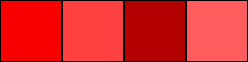
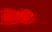
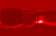
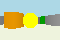

In [11]:
def vision_network(actf):
    net = cx.Network("Vision Controller")
    net.add(cx.ImageLayer("img_input", (40,60), 3),
            cx.Conv2DLayer("conv1", 10, (5, 5), 
                        activation=actf),
            cx.Conv2DLayer("conv2", 10, (5, 5), 
                        activation=actf),
            cx.MaxPool2DLayer("pool1", 
                           pool_size=(2,2)),
            cx.FlattenLayer("flatten"),
            cx.Layer("hidden", 20, 
                  activation=actf),
            cx.Layer("output", 4, 
                  activation="softmax"))
    net.connect()
    net.compile(loss="categorical_crossentropy", 
                optimizer="adam")
    return net

net = vision_network("relu")
net["conv1"].feature = 7
net.picture(vision_images[0])


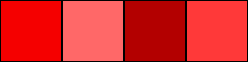
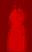
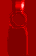
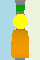

In [14]:
net.picture(vision_images[19], rotate=True)


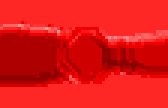
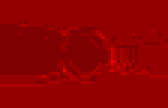
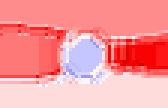
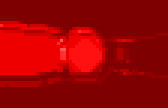
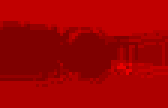
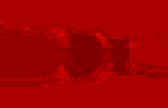
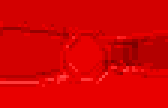
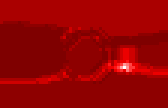
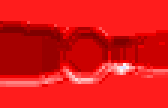
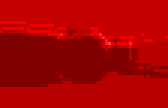

In [15]:
net.propagate_to_features("conv1", vision_images[10], scale=3)


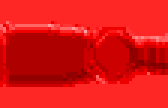
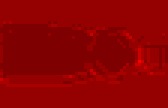
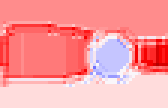
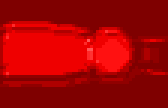
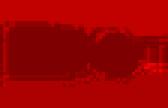
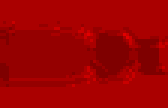
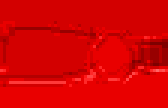
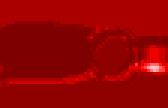
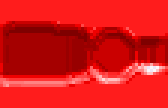
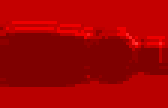

In [16]:
net.propagate_to_features("conv1", vision_images[20], scale=3)

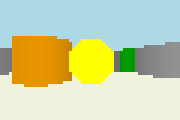

In [17]:
img = cx.array_to_image(vision_images[0], scale=3.0)
img


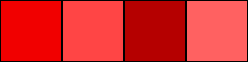
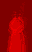
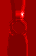
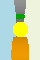

In [18]:
net.picture(vision_images[10], rotate=True)


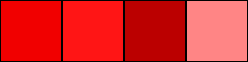
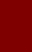
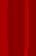
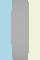

In [19]:
net.picture(vision_images[100], rotate=True)


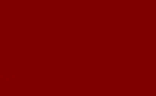
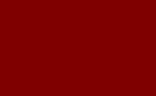
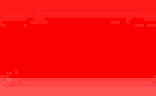
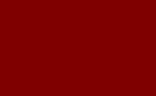
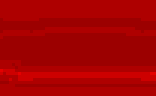
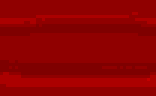
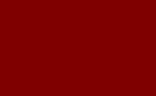
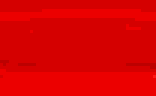
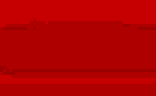
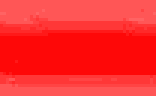

In [20]:
net.propagate_to_features("conv2", vision_images[100], scale=3.0)

In [21]:
ds = net.dataset

In [22]:
ds.clear()

In [23]:
%%time
dataset = []
for i in range(len(vision_images)):
    dataset.append([vision_images[i], cx.onehot(vision_targets[i] - 1, 4)])
ds.load(dataset)

CPU times: user 182 ms, sys: 28.1 ms, total: 210 ms
Wall time: 200 ms


In [24]:
ds.split(.1)

In [25]:
ds.summary()

_________________________________________________________________
Vision Controller Dataset:
Patterns    Shape                 Range                         
inputs      (40, 60, 3)           (0.0, 1.0)                    
targets     (4,)                  (0.0, 1.0)                    
Total patterns: 2000
   Training patterns: 1800
   Testing patterns: 200
_________________________________________________________________


In [26]:
#net.delete()
#net.train(5, report_rate=1, plot=True)
#net.save()

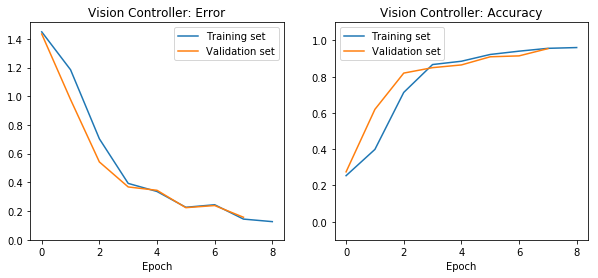

In [27]:
if net.saved():
    net.load()
    net.plot_results()
else:
    net.train(5, report_rate=1, save=True)

In [28]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

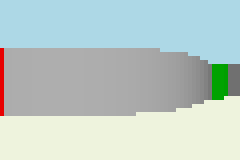

In [29]:
robot["camera"].getImage().resize((240, 160))

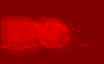

In [30]:
image = net.propagate_to_image("conv2", vision_images[0], scale=2.0)
image


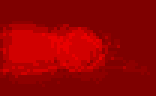
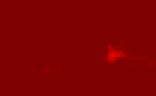
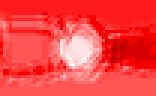
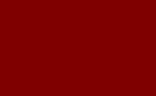
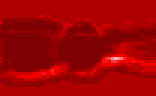
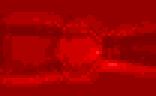
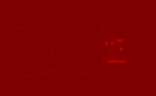
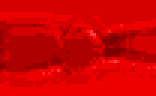
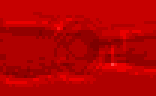
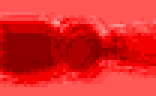

In [31]:
net.propagate_to_features("conv2", vision_images[0], scale=3.0)

In [32]:
net.propagate(vision_images[10])

[9.008902998597357e-12,
 0.002418647985905409,
 0.006460414733737707,
 0.9911209940910339]

In [33]:
net.propagate(cx.array_to_image(robot["camera"].getData()))

[3.493300255286158e-06,
 0.9392081499099731,
 0.06070834398269653,
 8.00939742475748e-05]

In [34]:
from conx.widgets import CameraWidget

In [35]:
cam = CameraWidget()
cam

<IPython.core.display.Javascript object>

CameraWidget()

In [30]:
image = cam.get_image().resize((60, 40))

In [31]:
net.propagate(image)

[0.0010676287347450852,
 0.8014371395111084,
 0.11032900214195251,
 0.08716624975204468]

In [32]:
net.propagate(robot["camera"].getData())

[0.024557704105973244,
 0.4533555805683136,
 0.41964301466941833,
 0.10244368016719818]

In [33]:
net.evaluate()

Testing validation dataset with tolerance 0.1...
Total count: 1800
      correct: 1335
      incorrect: 465
Total percentage correct: 0.7416666666666667


In [37]:
def network_brain(robot):
    if robot.mystep % 200 == 0:
        robot.priority = "left" if robot.priority == "right" else "right"
    inputs = robot["camera"].getData()
    outputs = net.propagate(inputs)
    print(net.pf(outputs))
    sonar = robot["sonar"].getData()
    left = min(sonar[0:4])
    right = min(sonar[4:8])
    clearance = 0.5
    noise = random.gauss(0, 0.2)
    if robot.priority == "left":
        if left < clearance or right < clearance:
            robot.move(0, -0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    else:
        if left < clearance or right < clearance:
            robot.move(0, 0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    robot.mystep += 1

In [38]:
net.visualize = False
robot = make_robot()
robot.brain = network_brain
robot.mystep = 0
robot.priority = random.choice(["left", "right"])
vsim = jy.VSimulator(robot, make_world)